## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
from lace.emulator import gp_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import data_QMLE_Ohio
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Decide number of IGM free parameters (need to set this before creating theory)

In [2]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=2
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

### Setup real P1D measurement we are trying to mock

This will be use to get the list of redshifts, wavenumbers and covariances

In [3]:
# setup data to mimic, with a maximum z to avoid redshifts not emulated
data=data_Chabanier2019.P1D_Chabanier2019(zmin=2.0,zmax=4.5)
#data=data_QMLE_Ohio.P1D_QMLE_Ohio(zmin=2.0,zmax=4.5)
print(data.z)

[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4]


### Setup emulator and theory

The emulator will be used both to make a mock, and in the likelihood 

In [4]:
basedir="/lace/emulator/sim_suites/Australia20/"
emu=gp_emulator.GPEmulator(basedir=basedir,emu_type="polyfit",kmax_Mpc=8,
                           asymmetric_kernel=True,rbf_only=True,
                           drop_tau_rescalings=True,train=True)
theory=lya_theory.Theory(zs=data.z,emulator=emu,free_param_names=free_param_names)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.40 seconds


In [5]:
# print parameter values used to create mock data
for p in theory.get_parameters():
    print(p.info_str(all_info=True))

ombh2 = 0.022 , 0.018 , 0.026
omch2 = 0.12 , 0.1 , 0.14
As = 2.1e-09 , 1e-09 , 3.2e-09
ns = 0.965 , 0.88 , 1.05
mnu = 0.0 , 0.0 , 1.0
nrun = 0.0 , -0.8 , 0.8
H0 = 67.0 , 50 , 100
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_kF_1 = 0.0 , -0.4 , 0.4


### Create mock P1D data

Use Lya theory to mimic mock data

In [6]:
mock=mock_data.Mock_P1D(data=data,theory=theory)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [7]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=mock,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=prior_Gauss_rms,
                            emu_cov_factor=emu_cov_factor)

As = 2.0999999999999998e-09 , 1e-09 , 3.2e-09
ns = 0.9650000000000001 , 0.88 , 1.05
ln_tau_0 = 0.0 , -0.1 , 0.1
ln_sigT_kms_0 = 0.0 , -0.4 , 0.4
ln_gamma_0 = 0.0 , -0.2 , 0.2
ln_kF_0 = 0.0 , -0.2 , 0.2
ln_tau_1 = 0.0 , -0.2 , 0.2
ln_sigT_kms_1 = 0.0 , -0.4 , 0.4
ln_gamma_1 = 0.0 , -0.4 , 0.4
ln_kF_1 = 0.0 , -0.4 , 0.4
chi2 = -0.0


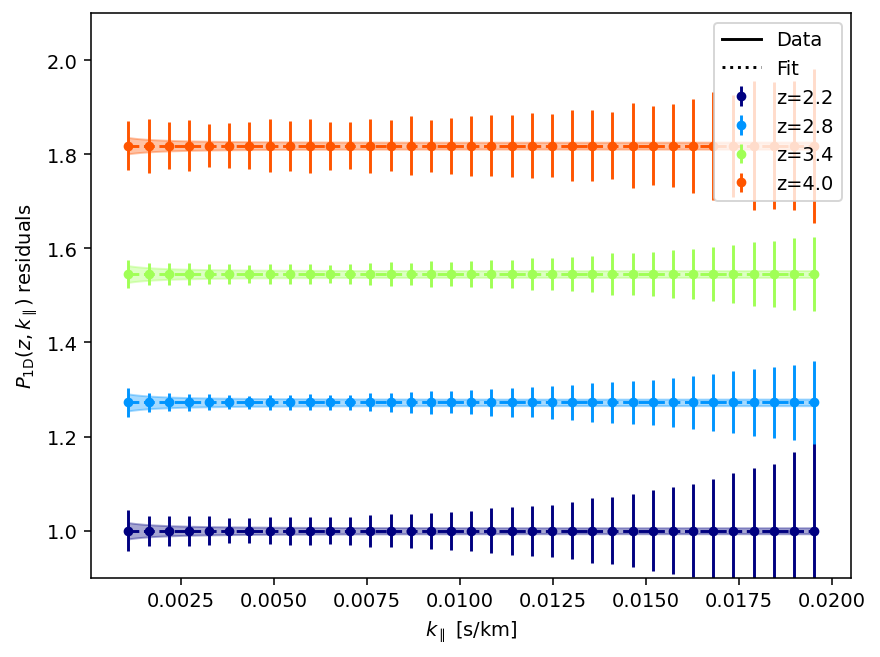

In [8]:
# check starting point for free parameters (should be equal to truth)
test_values=len(free_param_names)*[0.5]
for p in like.parameters_from_sampling_point(values=test_values):
    print(p.info_str(all_info=True))
print('chi2 =',like.get_chi2(values=test_values))
like.plot_p1d(values=test_values,residuals=True,plot_every_iz=3)

### Run iminuit minimizer

In [9]:
# choose starting point for free parameters (within 0.5 +/- ini_sigma, in the unit cube)
ini_sigma=0.1
ini_values=2*ini_sigma*np.random.random(len(like.free_params))+0.5-ini_sigma
print('ini values',ini_values)
for p in like.parameters_from_sampling_point(values=ini_values):
    print(p.info_str(all_info=True))

ini values [0.44832558 0.45880528 0.54079341 0.57223116 0.48996029 0.58474546
 0.56070916 0.44576593 0.44325681 0.42377506]
As = 1.9863162787357783e-09 , 1e-09 , 3.2e-09
ns = 0.9579968976425695 , 0.88 , 1.05
ln_tau_0 = 0.008158681980045102 , -0.1 , 0.1
ln_sigT_kms_0 = 0.05778492933404411 , -0.4 , 0.4
ln_gamma_0 = -0.004015885214447901 , -0.2 , 0.2
ln_kF_0 = 0.033898183544148974 , -0.2 , 0.2
ln_tau_1 = 0.024283662344481705 , -0.2 , 0.2
ln_sigT_kms_1 = -0.04338725681237543 , -0.4 , 0.4
ln_gamma_1 = -0.04539455020003824 , -0.4 , 0.4
ln_kF_1 = -0.060979951434373736 , -0.4 , 0.4


In [10]:
minimizer = iminuit_minimizer.IminuitMinimizer(like,ini_values=ini_values)

In [11]:
minimizer.minimize(compute_hesse=True)

In [12]:
# what is the chi2 of the best-fit? (should be close to 0)
best_fit_values=np.array(minimizer.minimizer.values)
like.get_chi2(values=best_fit_values)

5.5693193826598763e-05

In [13]:
# what was the chi2 of the starting point?
like.get_chi2(values=ini_values)

51.70460723800325

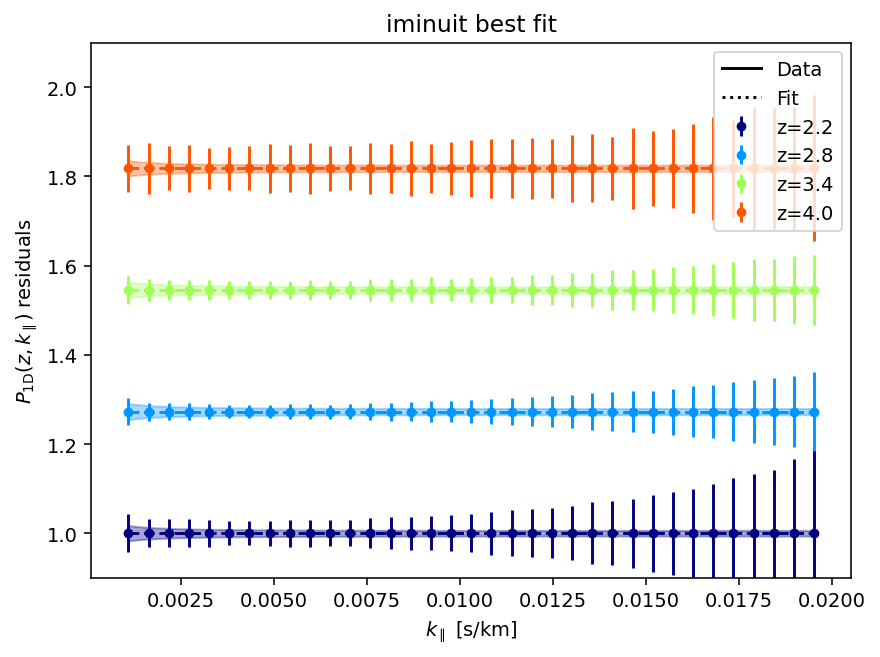

In [14]:
minimizer.plot_best_fit(plot_every_iz=3)

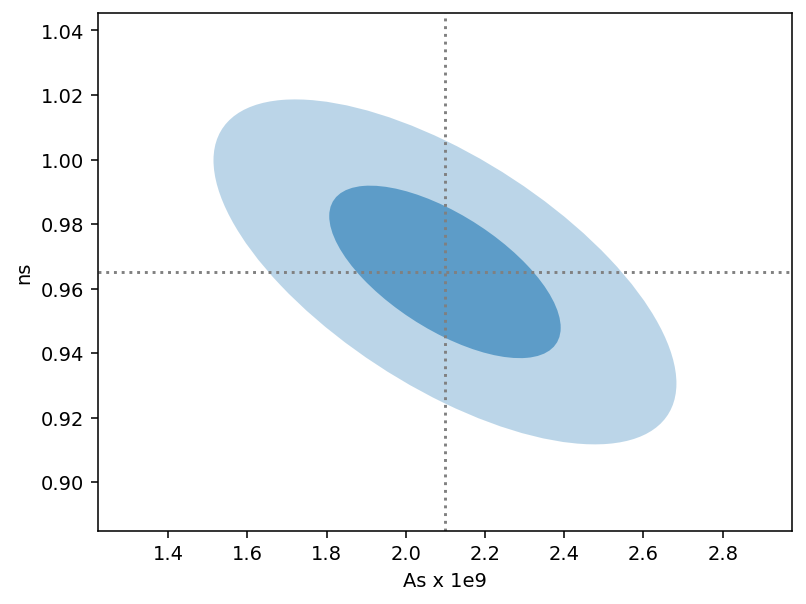

In [15]:
minimizer.plot_ellipses('As','ns')

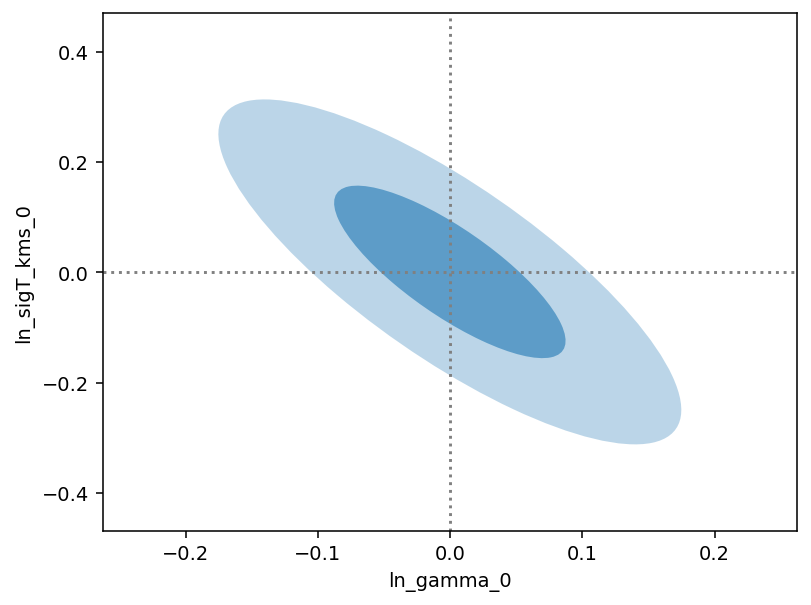

In [16]:
minimizer.plot_ellipses('ln_gamma_0','ln_sigT_kms_0')

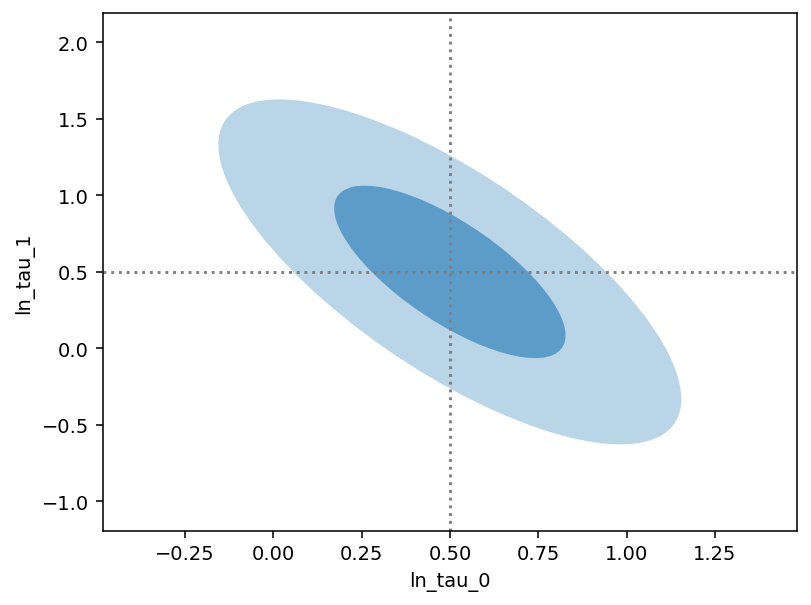

In [17]:
minimizer.plot_ellipses('ln_tau_0','ln_tau_1',cube_values=True)

In [18]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 153.5                      │              Nfcn = 852              │
│ EDM = 1.16e-07 (Goal: 0.0001)    │           time = 11.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.50    │   0.13    │            │            │         │         │       │
│ 1 │ x1   │   0.50    │   0.15    │            │            │         │         │       │
│ 2 │ x2   │   0.50    │   0.33    │            │            │         │         │       │
│ 3 │ x3   │   0.50    │   0.19    │            │            │         │         │       │
│ 4 │ x4   │   0.50    │   0.22    │            │            │         │         │       │
│ 5 │ x5   │    0.5    │    0.4    │            │            │         │         │       │
│ 6 │ x6   │    0.5    │    0.6    │            │            │         │         │       │
│ 7 │ x7   │    0.5    │    0.6    │            │            │         │         │       │
│ 8 │ x8   │    0.5    │    0.5    │            │            │         │         │       │
│ 9 │ x9   │    0.5    │    0.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5       x6       x7       x8       x9 │
├────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│ x0 │   0.0166  -0.0119  -0.0193 -0.00998 -0.00216   0.0473   0.0487 -0.00619   0.0375  -0.0285 │
│ x1 │  -0.0119   0.0224  -0.0135    0.023  -0.0152  -0.0581 -0.00958  -0.0376 -0.00836   0.0207 │
│ x2 │  -0.0193  -0.0135    0.107   -0.037   0.0624 -0.00202   -0.137     0.12  -0.0986  0.00925 │
│ x3 │ -0.00998    0.023   -0.037   0.0349  -0.0321  -0.0612   0.0178  -0.0636   0.0112   0.0332 │
│ x4 │ -0.00216  -0.0152   0.0624  -0.0321   0.0465   0.0257  -0.0622   0.0764  -0.0377  -0.0159 │
│ x5 │   0.0473  -0.0581 -0.00202  -0.0612   0.0257    0.185   0.0829   0.0744   0.0645   -0.094 │
│ x6 │   0.0487 -0.00958   -0.137   0.0178  -0.0622   0.0829    0.316   -0.264    0.237  -0.0224 │
│ x7 │ -0.00619  -0.0376     0.12  -0.0636   0.0764   0.0744   -0.264    0.391   -0.177  -0.0983 │
│ x8 │   0.0375 -0.00836  -0.0986   0.0112  -0.0377   0.0645    0.237   -0.177    0.204  -0.0308 │
│ x9 │  -0.0285   0.0207  0.00925   0.0332  -0.0159   -0.094  -0.0224  -0.0983  -0.0308    0.154 │
└────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [19]:
minimizer.minimizer.errors

<ErrorView x0=0.128794611184624 x1=0.14955072801266173 x2=0.32673216246297404 x3=0.1869037089225428 x4=0.21565378925668496 x5=0.43035422179717714 x6=0.56252926368951 x7=0.6253227767465117 x8=0.4513135412646451 x9=0.39276349234570207>

In [20]:
minimizer.best_fit_value('ln_tau_0',return_hesse=True)

(3.1578168831203346e-07, 0.06534643249259481)